# Transfer Learning - TF MobileNetV2 Alpaca Classifier
## (by Youssef Hussein Ahmed)

### Contact with me:
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/linkedin.svg" />][linkedin]
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/upwork.svg" />][upwork]
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/github.svg" />][github]
[<img align="left" width="35px" style= "padding-right: 10px" src="https://cdn.jsdelivr.net/npm/simple-icons@v3/icons/facebook.svg" />][facebook]

[linkedin]: https://www.linkedin.com/in/just-youssef
[upwork]: https://www.upwork.com/freelancers/~01bf41aeaec6f293c5
[github]: https://github.com/just-youssef
[facebook]: https://www.facebook.com/just.johnny99

## Table of Content

- [1 - Packages](#1)
- [2 Create the Dataset and Split it into Training and Validation Sets](#2)
    - [2.1 - Data_Pre-processing](#2-1)
    - [2.2 - Data_Augmentation](#2-2)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Building alpaca_model](#3-2)
    - [3.3 - Training alpaca_model](#3-3)
- [4 - Fine-tuning the Model](#4)
    - [4.1 - Continue Training ](#4-1)

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='2'></a>
## 2 - Create the Dataset and Split it into Training and Validation Sets

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Now let's take a look at some of the images from the training set: 

**Note:** The original dataset has some mislabelled images in it as well.

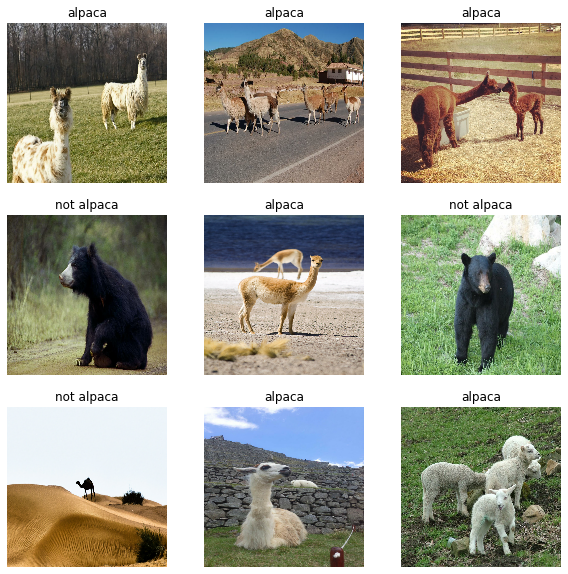

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2-1'></a>

### 2.1 - Data Preprocessing
Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk.

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# prefetch validation_dataset as well
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

MobileNetV2 model was trained on the normalization values [-1,1]

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='2-2'></a>
### 2.2 - Data Augmentation

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip(mode='horizontal'))
    data_augmentation.add(RandomRotation(factor=0.2))
    
    return data_augmentation

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<img src="images/mobilenetv2.png" style="width:650px;height:450px;">

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections speed up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

<a name='3-2'></a>
### 3.2 - Building `alpaca_model`

In [7]:
def alpaca_model(input_shape=(160, 160, 3), data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
            
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,  # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(rate=0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units=1, activation='linear')(x)
        
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [8]:
model = alpaca_model()

9420800/9406464 [==============================] - 9s 1us/step


<a name='3-3'></a>
### 3.3 - Training `alpaca_model`

In [12]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 15s 1s/step - loss: 0.6815 - accuracy: 0.5725 - val_loss: 0.5180 - val_accuracy: 0.6308
Epoch 2/5
9/9 [==============================] - 8s 759ms/step - loss: 0.5238 - accuracy: 0.7176 - val_loss: 0.4019 - val_accuracy: 0.7385
Epoch 3/5
9/9 [==============================] - 9s 831ms/step - loss: 0.4700 - accuracy: 0.7672 - val_loss: 0.3924 - val_accuracy: 0.7385
Epoch 4/5
9/9 [==============================] - 9s 797ms/step - loss: 0.4288 - accuracy: 0.7443 - val_loss: 0.3229 - val_accuracy: 0.8154
Epoch 5/5
9/9 [==============================] - 8s 770ms/step - loss: 0.3526 - accuracy: 0.8092 - val_loss: 0.2727 - val_accuracy: 0.8615


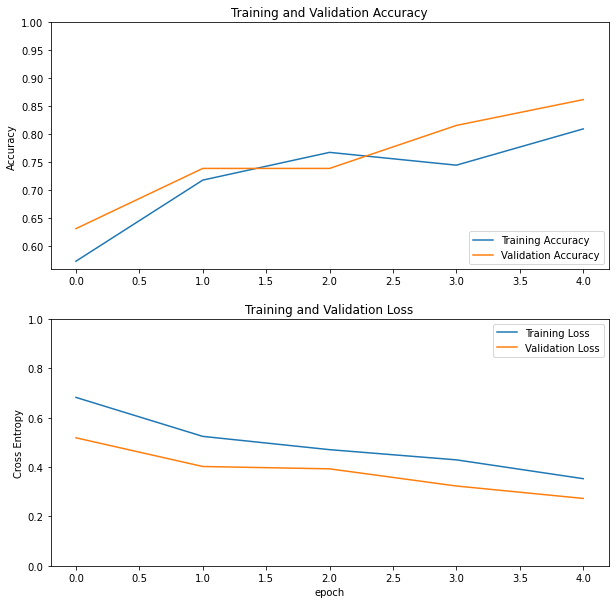

In [14]:
# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The results are ok, but could be better. Next, try some fine-tuning.

<a name='4'></a>
## 4 - Fine-tuning `alpaca_model`

Unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

In [17]:
model.layers

In [18]:
# Retrieve base_model (layer 4)
base_model = model.layers[4]
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [21]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(0.1 * base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=metrics)

<a name='4-1'></a>
### 4.1 - Continue Training

In [24]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 10s 960ms/step - loss: 0.1106 - accuracy: 0.9656 - val_loss: 0.0444 - val_accuracy: 0.9846
Epoch 6/10
9/9 [==============================] - 10s 945ms/step - loss: 0.0980 - accuracy: 0.9504 - val_loss: 0.0942 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 10s 934ms/step - loss: 0.0891 - accuracy: 0.9733 - val_loss: 0.0471 - val_accuracy: 0.9846
Epoch 8/10
9/9 [==============================] - 10s 967ms/step - loss: 0.0875 - accuracy: 0.9656 - val_loss: 0.0369 - val_accuracy: 1.0000
Epoch 9/10
9/9 [==============================] - 10s 973ms/step - loss: 0.0453 - accuracy: 0.9885 - val_loss: 0.0492 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 10s 968ms/step - loss: 0.0360 - accuracy: 0.9885 - val_loss: 0.0499 - val_accuracy: 0.9846


Ahhh, quite an improvement! A little fine-tuning can really go a long way.

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

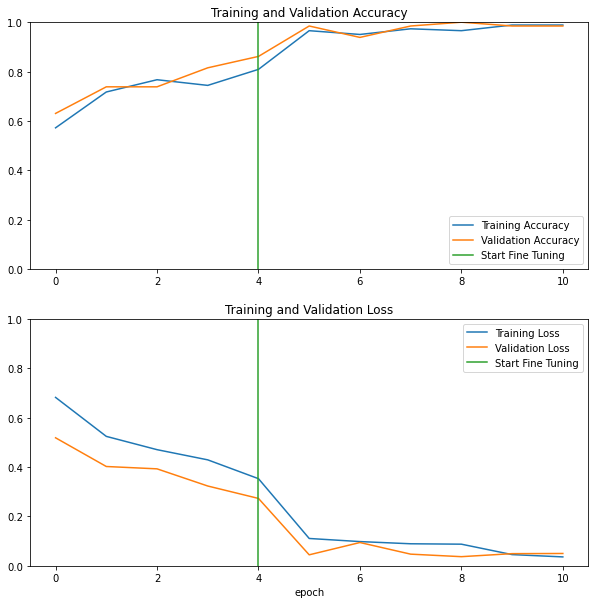

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()